## CS 5630 Final Project   
Decision Tree Classifiers   
Dan Mrachko   

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Load Metrics: I copied this from Aleksei because I like the way he did it.   

Small change: pos_label in specificity is 1 because of how I encoded the output (I want True violent crimes as positive label)   

In [34]:
def all_metrics(y_true, y_pred):
    print("accuracy:\t{:.3f}".format(metrics.accuracy_score(y_true, y_pred)))
    print("sensitivity: \t{:.3f}".format(metrics.recall_score(y_true, y_pred)))
    print("specificity: \t{:.3f}".format(metrics.recall_score(y_true, y_pred, pos_label=1)))
    print("kappa:    \t{:.3f}".format(metrics.cohen_kappa_score(y_true, y_pred)))

### Load the San Francisco data and prep for modeling

In [35]:
data = pd.read_csv('../data/cleaned_data/SanFrancisco.csv')
data.head(5)

# drop low/no correlation columns
data.drop(inplace=True, columns=['Unnamed: 0', 'Dates', 'Category', 'street1', 'street2', 'Address'])
# keeping str1 and str2 for now

data['violent'].value_counts()

# integer-encode 'violent' before splitting into testing and training data
encode_map = {"violent": {True:1, False:0}}
violent_map = ['False','True']
data = data.replace(encode_map)

data.head(5)


,DayOfWeek,PdDistrict,X,Y,year,month,day,hour,violent,str1,str2
0,2,NORTHERN,-122.425892,37.774599,2015,5,13,23,1,OAK ST,LAGUNA ST
1,2,NORTHERN,-122.425892,37.774599,2015,5,13,23,0,OAK ST,LAGUNA ST
2,2,NORTHERN,-122.424363,37.800414,2015,5,13,23,0,VANNESS AV,GREENWICH ST
3,2,NORTHERN,-122.426995,37.800873,2015,5,13,23,0,other,other
4,2,PARK,-122.438738,37.771541,2015,5,13,23,0,other,other


### Split into training and testing

In [36]:
y_data = data.loc[:,'violent']
x_data = data.loc[:,data.columns!='violent']

# convert all non-numeric columns in x to dummie values
x_data = pd.get_dummies(x_data)

#80-20 split
testing_size = 0.2
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=testing_size, random_state = 12)

# verify
print(f'X training size: {x_train.shape}')
print(f'Y training size: {y_train.shape}')
print(f'X testing size: {x_test.shape}')
print(f'Y testing size {y_test.shape}')

x_data.head()

X training size: (702385, 419)
Y training size: (702385,)
X testing size: (175597, 419)
Y testing size (175597,)


,DayOfWeek,X,Y,year,month,day,hour,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,...,str2_VANNESS AV,str2_VERMONT ST,str2_VICENTE ST,str2_WALLER ST,str2_WASHINGTON ST,str2_WEBSTER ST,str2_WINSTON DR,str2_WISCONSIN ST,str2_YORK ST,str2_other
0,2,-122.425892,37.774599,2015,5,13,23,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,-122.425892,37.774599,2015,5,13,23,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,-122.424363,37.800414,2015,5,13,23,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,-122.426995,37.800873,2015,5,13,23,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2,-122.438738,37.771541,2015,5,13,23,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Define a K-fold object for cross-validation

In [37]:
kfold = KFold(n_splits=10, shuffle=True, random_state=13)

### Hyperparameter tuning

In [38]:
tree_class = DecisionTreeClassifier(random_state=14)

tree_params = {'criterion':['gini','entropy'],
               'splitter':['best'],
               'max_depth':[2, 5, None],
               'min_samples_split':[2,3,5],
               'max_features':['sqrt','log2',None]}

tree_grid = GridSearchCV(estimator=tree_class,
                         param_grid=tree_params,
                         scoring='accuracy',
                         cv=kfold)

# train the grid
tree_grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=13, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=14),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_split': [2, 3, 5], 'splitter': ['best']},
             scoring='accuracy')

### Best Parameters from Tuning

In [39]:
# Print out the best parameters:
print(f'Best Parameters: {tree_grid.best_params_}')
print(f'with Accuracy: {tree_grid.best_score_}')

Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_split': 2, 'splitter': 'best'}
with Accuracy: 0.5852616481865265


### Fit tree using tuned parameters

In [40]:
tree_model = DecisionTreeClassifier(
    criterion=tree_grid.best_params_['criterion'],
    max_depth=tree_grid.best_params_['max_depth'],
    max_features=tree_grid.best_params_['max_features'],
    min_samples_split=tree_grid.best_params_['min_samples_split'],
    splitter=tree_grid.best_params_['splitter'],
    random_state=15
)

tree_model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=15)

# Predict on Training set and Testing Set, display performance metrics

accuracy:	0.584
sensitivity: 	0.559
specificity: 	0.559
kappa:    	0.169


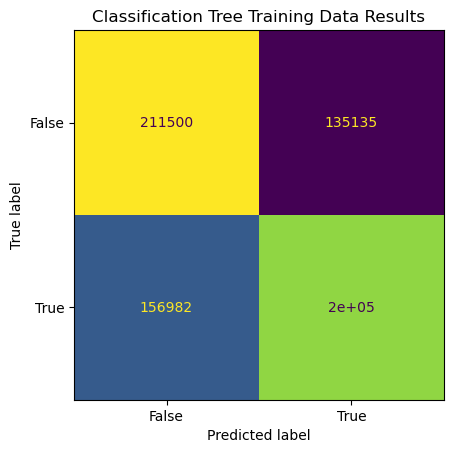

In [67]:
y_pred_train = tree_model.predict(x_train)
cm_training = confusion_matrix([violent_map[val] for val in y_train], [violent_map[val] for val in y_pred_train])

ConfusionMatrixDisplay(confusion_matrix=cm_training, display_labels=violent_map).plot(colorbar=False)
plt.title('Classification Tree Training Data Results')
plt.savefig('Class_tree_conf_mat_training.png')

all_metrics(y_train, y_pred_train)

In [66]:
cm_training

array([[211500, 135135],
       [156982, 198768]], dtype=int64)

accuracy:	0.584
sensitivity: 	0.558
specificity: 	0.558
kappa:    	0.169


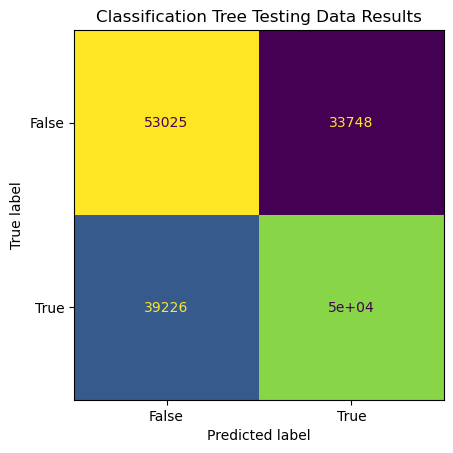

In [68]:
y_pred_test = tree_model.predict(x_test)
cm_testing = confusion_matrix([violent_map[val] for val in y_test], [violent_map[val] for val in y_pred_test])

ConfusionMatrixDisplay(confusion_matrix=cm_testing, display_labels=violent_map).plot(colorbar=False)
plt.title('Classification Tree Testing Data Results')
plt.savefig('Class_tree_conf_mat_testing.png')

all_metrics(y_test, y_pred_test)

### Plot the tree

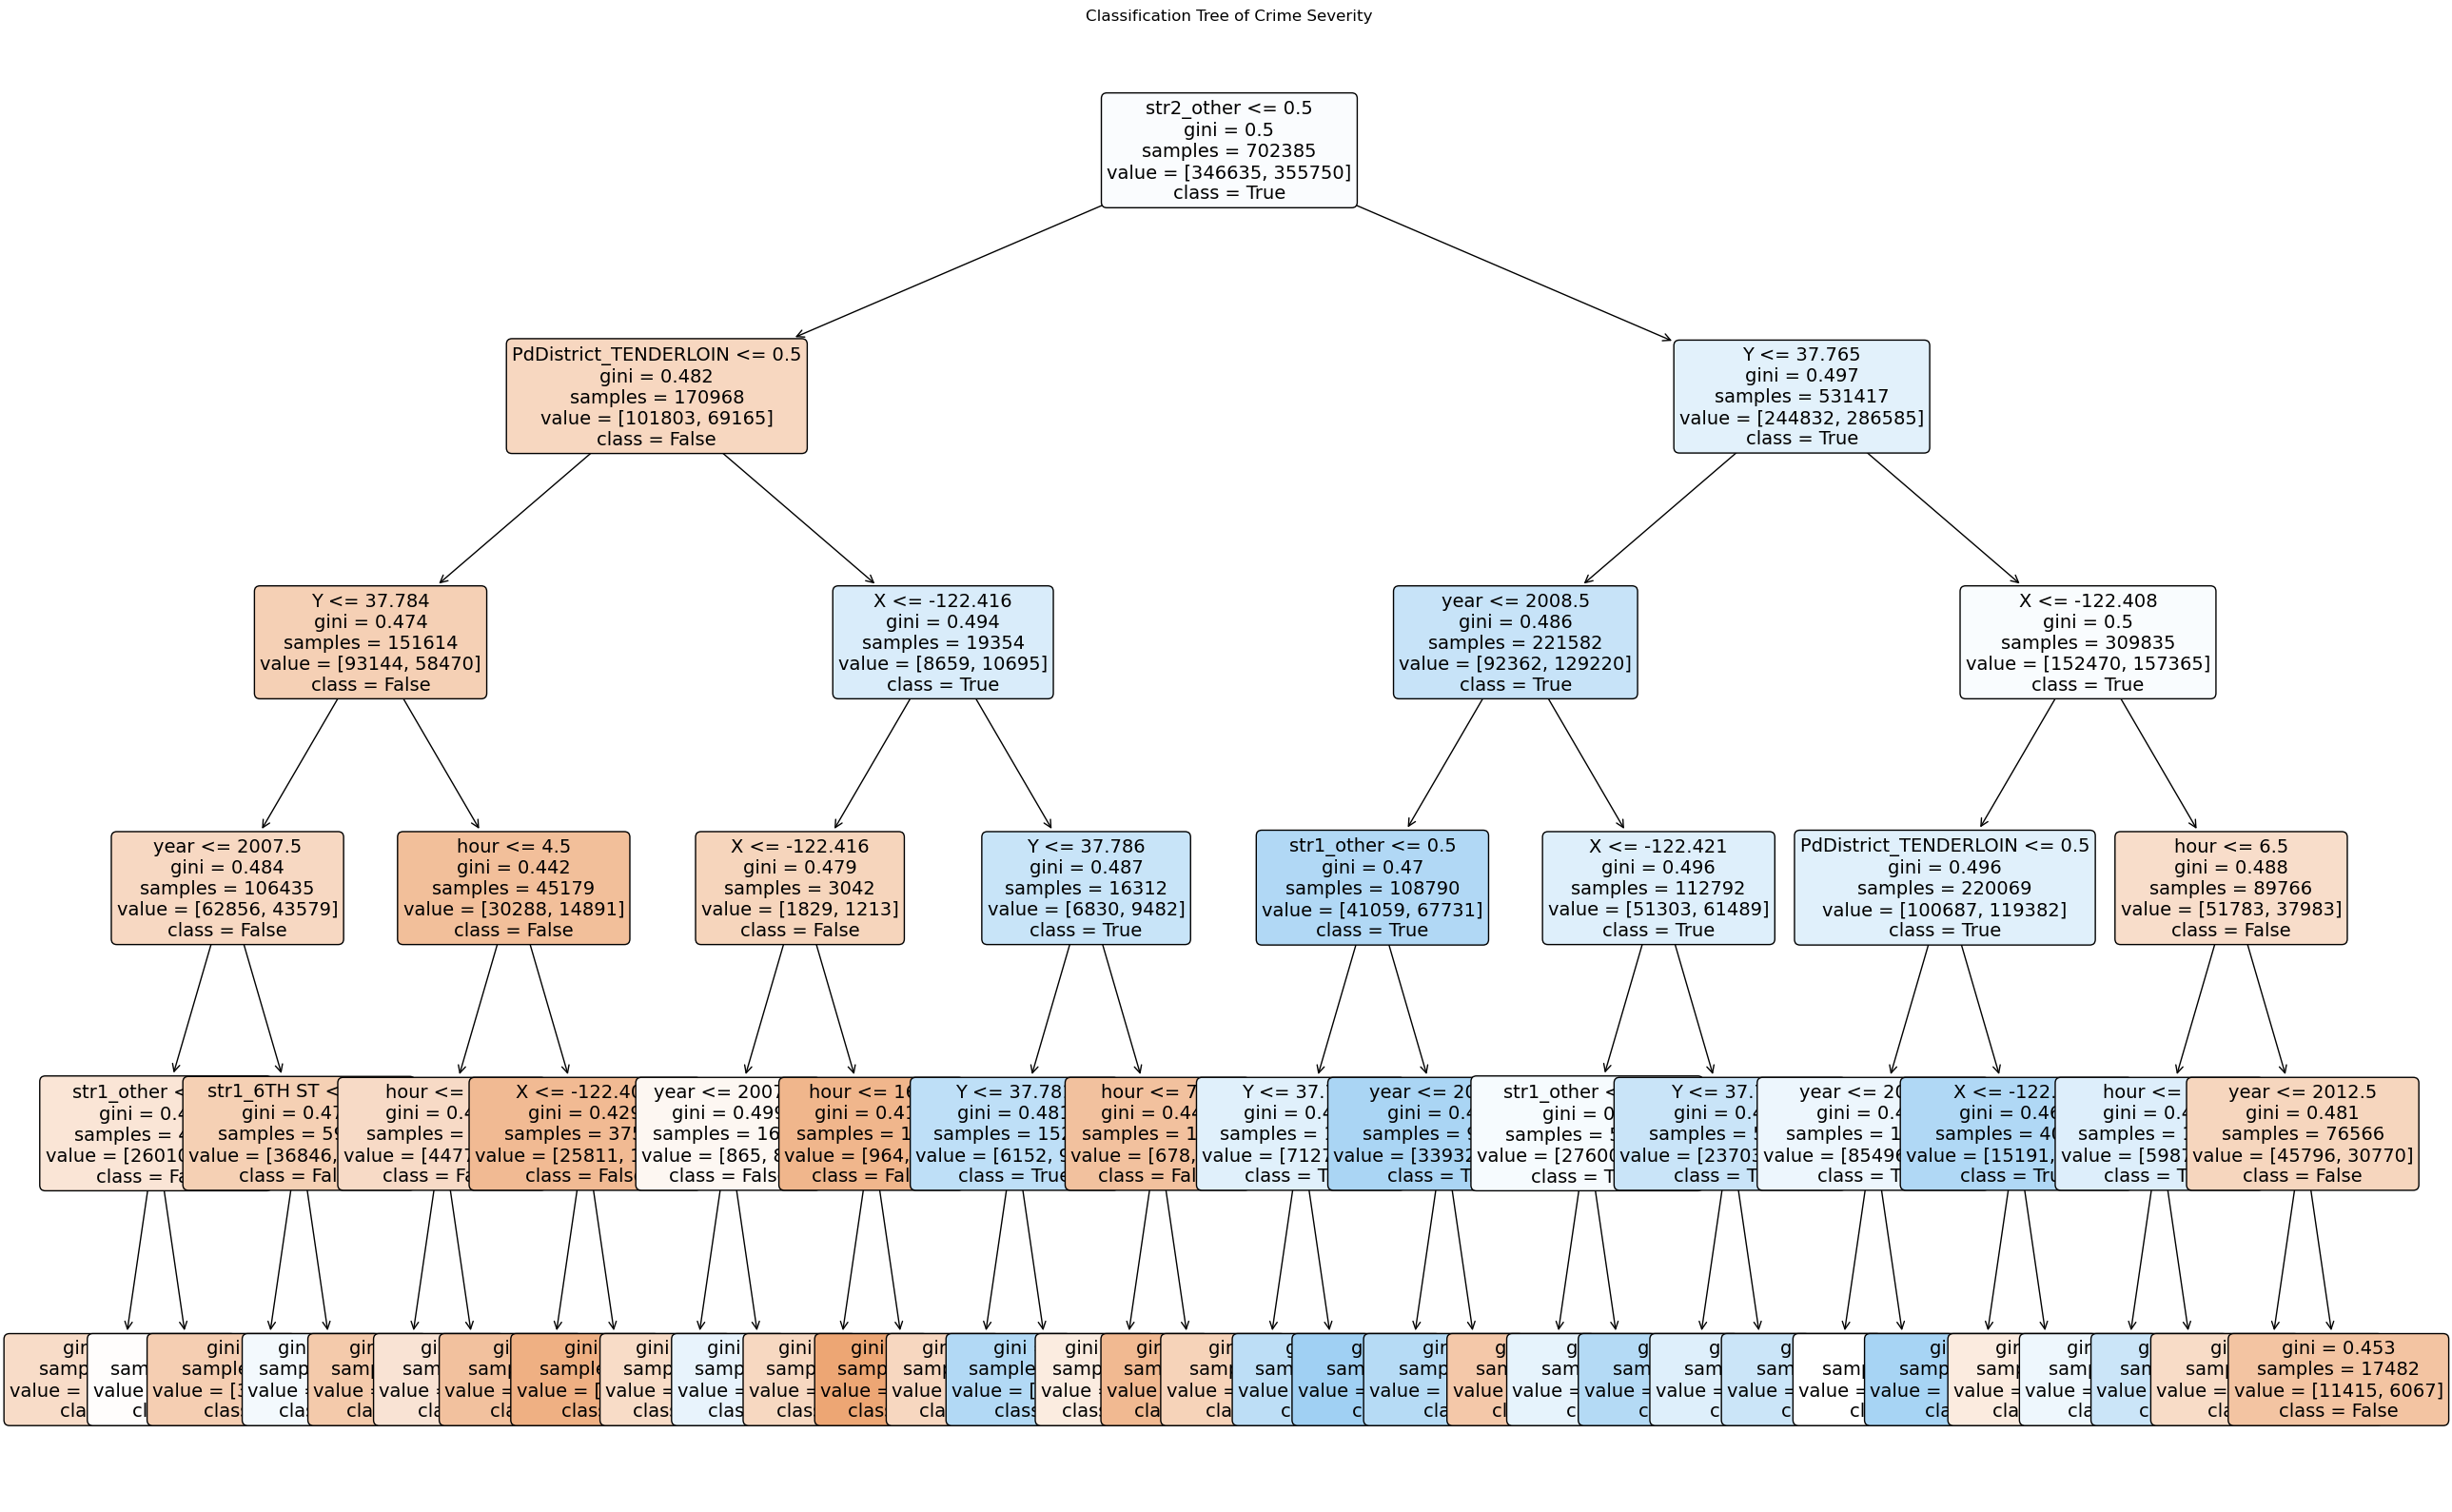

In [60]:
plt.figure(figsize=(26,16))
tree.plot_tree(tree_model, feature_names=x_data.columns, class_names=['False','True'],
               filled=True, rounded=True, fontsize=14)

plt.title('Classification Tree of Crime Severity')
plt.tight_layout()

plt.savefig('classification_tree.png')